### Retrieve GHG emissions from forest fires

_Author_: Chiara Aquino
<br>
_Date_: 12 March 2024

This script provides the functions used to calculate GHG emissions from forest fires. GHG emissions are calculated using the model from in Chiriacò et al.(2013):

    GHG emissions = A x B x C x D x 10-3 

where: 
<br>
GHG emissions = amount of GHGs released as a result of fire [kgton of GHG]; 
<br>
A = burnt area [ha], provided by input data (EFFIS) 
<br>
B = mass of available fuels, in [kg dry matter ha-1]
<br>
C = combustion factor, portion of biomass combusted [dimensionless]
<br>
D = emission factor [g GHG kg–1] for each GHG compound. 

**Reference**
<br>
Chiriaco, M.V., Perugini, L., Cimini, D., D’Amato, E., Valentini, R., Bovio, G., Corona, P. and Barbati, A., 2013. Comparison of approaches for reporting forest fire-related biomass loss and greenhouse gas emissions in southern Europe. _International Journal of Wildland Fire_, 22(6), pp.730-738.


In [24]:
#import libraries
import geopandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### GHG functions

In [29]:
def import_data(path_to_data_location,path_to_italian_regions_shapefile,crs,region=None,**kwargs):

    """
    Retrieve burnt area polygon from the shapefile and filter it based on selected columns and values.

    Parameters:
    - path_to_data_location (string) : location of the EFFIS shapefile, as downloaded from https://effis.jrc.ec.europa.eu/applications/data-and-services 
    - path_to_italian_regions (string) : location of the shapefile containing Italian regions
    - crs (string) : coordinate reference system of choice
    - region (string) : name of Italian region
    - *kwargs: Optional arguments for column name and corresponding values.

    Returns:
    - pd.DataFrame: Filtered DataFrame.
    """

    #open shapefile as DataFrame
    df = geopandas.read_file(path_to_data_location)
    
    #Copy the original DataFrame
    filtered_df = df.copy()
       
    #extract year from EFFIS date column so that the DataFrame can be filtered by year only
    filtered_df['FIREDATE'] = pd.to_datetime(filtered_df['FIREDATE'], format="mixed")
    filtered_df['YEAR'] = filtered_df['FIREDATE'].dt.year
    filtered_df = filtered_df.rename(columns={"FIREDATE": "DATE"})
    
    #rename id column to avoid confusion
    filtered_df.rename(columns={'id': 'ID'}, inplace=True)
    
    #filter by selected columns specified in optional arguments
    for column, value in kwargs.items():
        #filter only for values that have been declared in function
        if value is not None: #if we have declared a value

            if column not in filtered_df.columns or filtered_df[column].empty: #what if that column we want doesnt exist in the data?
                print(f"No data found where '{column}' is '{value}'.") #then just ignore and restart the function
                continue
            else:
                filtered_df = filtered_df[filtered_df[column] == value] # we have value that matches the entry of a valid column, hence filter df by this condition
                
                #clip shapefile to Italian region
                if region: 
                    italian_regions = geopandas.read_file(path_to_italian_regions_shapefile)
                    italian_regions = italian_regions[italian_regions['DEN_REG'] == region]
                
                    #make sure both regions and the burnt area shapefile are in the same crs
                    italian_regions = italian_regions.to_crs(crs)
                    filtered_df= filtered_df.to_crs(crs)
                
                    #clip burnt area shapefile with italian region shapefile
                    filtered_df = geopandas.clip(filtered_df,italian_regions)

    return filtered_df
                

def get_landcover_classes(landcover,path_to_landcover_legend,language):

    """
    Retrieve landcover classes from the landcover shapefile and filter it based on selected columns and values.

    Parameters:
    - landcover (string): name of landcover type to use (e.g., if Corine or EFFIS)
    - path_to_landcover_legend (string) : location of landcover legend table
    - language (string) : if 'English' or 'Italian'

    Returns:
    - classes (list of str)
    - names (list of str) 
    - colors (list of int) 
    """

    # get all classes, labels and associated colors
    landcover_legend = pd.read_csv(path_to_landcover_legend)
    classes = landcover_legend[landcover+"_CODE"].values.T.tolist()
    names = landcover_legend[landcover+"_NAME_"+language].values.T.tolist()
    colors = landcover_legend[landcover+"_COLOR"].values.T.tolist()

    # drop Nan in the list
    classes = [x for x in classes if not pd.isna(x)]
    names = [x for x in names if not pd.isna(x)]
    colors = [x for x in colors if not pd.isna(x)]
    
    # Transform integers to strings
    classes = [str(i) for i in classes]
  
    return classes, names, colors  

def get_clc18_forest_types_in_burnt_shape(path_to_clc18_shapefile, df_burnt_area_shape, forest_classes,crs):

    """
    Filter corine (clc18) landcover classes by clipping corine landcover with the burnt area shapefile

    Parameters:
    - path_to_clc18_shapefile (string):  location of corine shapefile 
    - df_burnt_area_shape (pd.DataFrame): input DataFrame containing burnt area for the fire event 
    - forest_classes (list of str): forest classes 
    - crs (str) : chosen coordinate system, e.g "epsg:4326" 

    Returns:
    - CLC18_burnt_area : Filtered geopandas DataFrame with corine land cover classes in burnt area
    """

    # Read corine shapefile
    CLC18 = geopandas.read_file(path_to_clc18_shapefile)

    #make sure both corine and the burnt area shapefile are in the same crs
    CLC18 = CLC18.to_crs(crs)
    df_burnt_area_shape= df_burnt_area_shape.to_crs(crs)

    #clip Corine with the burnt area shapefile
    CLC18_burnt_area = geopandas.clip(CLC18, df_burnt_area_shape)

    return CLC18_burnt_area


def get_clc18_areas(path_to_clc18_shapefile, df_burnt_area_shape, forest_classes,crs):

    """
    Calculate areas of each corine landcover class within burnt area

    Parameters:
    - path_to_clc18_shapefile (string):  location of corine shapefile 
    - df_burnt_area_shape (pd.DataFrame): input DataFrame containing burnt area for the fire event 
    - forest_classes (list of str): forest classes 
    - crs (str) : chosen coordinate system, e.g "epsg:4326" 

    Returns:
    - clc18_sum_areas_by_forest_class : DataFrame containing areas of each corine land cover class in burnt area
    """
    import pandas as pd

    CLC18_burnt_area_forest_only = get_clc18_forest_types_in_burnt_shape(path_to_clc18_shapefile, df_burnt_area_shape, forest_classes,crs)
    
    #Use an equal-area projection to calculate area in m2
    CLC18_burnt_area_forest_only = CLC18_burnt_area_forest_only.to_crs({'proj':'cea'})
    CLC18_burnt_area_forest_only["Area_m2"] = CLC18_burnt_area_forest_only.geometry.area / 10000
    
    #groupby clc18 forest class, sum and convert from m2 to HA
    sum_areas_by_forest_class = CLC18_burnt_area_forest_only.groupby('CLC18')['Area_m2'].sum() 
    
    #convert array values into dataframe for all (grouped) landcover classes
    df_sum_areas_by_forest_class = pd.DataFrame(sum_areas_by_forest_class)
    df_sum_areas_by_forest_class = df_sum_areas_by_forest_class.reset_index()
    df_sum_areas_by_forest_class = df_sum_areas_by_forest_class.rename(columns={'Area_m2': 'AREA_HA'})

    #convert array values into dataframe for each single event
    df_burnt_area_all_events = pd.DataFrame(CLC18_burnt_area_forest_only)
    df_burnt_area_all_events = df_burnt_area_all_events.reset_index()
    df_burnt_area_all_events = df_burnt_area_all_events.rename(columns={'Area_m2': 'AREA_HA'})
    
    #get all the other forest classes from Corine landcover and order them in a table that can be joined to the previous one
    df_forest_classes = pd.DataFrame(columns=['CLC18', 'AREA_HA'])
    df_forest_classes['CLC18'] = forest_classes 
    
    #merge the two tables so we have ALL forest classes (including missing ones), with area=0 for the classes that do not exist in burnt area
    df_all_forest_classes = pd.merge(df_sum_areas_by_forest_class, df_forest_classes, how='outer')
    
    # eliminate the duplicates, but only for those that have area > 0 
    df_all_forest_classes = df_all_forest_classes.drop_duplicates(subset=['CLC18'], keep='first') 
    df_all_forest_classes = df_all_forest_classes.fillna(0)

    
    return df_all_forest_classes,df_burnt_area_all_events

def get_effis_areas(df_burnt_area_shape,forest_classes):

    """
    Calculate areas of each EFFIS landcover class within burnt area

    Parameters:
    - df_burnt_area_shape (pd.DataFrame): input DataFrame containing burnt area for the fire event 
    - forest_classes (list of str): forest classes 

    Returns:
    - effis_sum_areas_by_forest_class : DataFrame containing areas of each EFFIS land cover class in burnt area
    """
    
    for forest_class in forest_classes: 

        # Burnt areas in EFFIS for each forest class are reported in percentage units
        # To get areas for each burnt forest type in Ha, we need to 
        # multiply the proportion of each burnt forest type by total burnt area in Ha
        df_burnt_area_shape[forest_class+'_AREA_HA'] = df_burnt_area_shape[forest_class].astype(float)/ 100 * df_burnt_area_shape['AREA_HA'].astype(float) 
        
        # Retain in DataFrame only columns with burnt areas in hectares for each forest type
        df_areas_by_forest_class = df_burnt_area_shape.filter(regex='_AREA_HA')
    
        # Get TOTAL burnt areas in hectares for each forest type by summing over each column
        effis_sum_areas_by_forest_class = df_areas_by_forest_class.astype(float).sum(axis=0)

    # make result into a dataframe that can be used later as a multiplication factor
    df_effis_sum_areas_by_forest_class = pd.DataFrame(effis_sum_areas_by_forest_class)
    df_effis_sum_areas_by_forest_class = df_effis_sum_areas_by_forest_class.reset_index()
    df_effis_sum_areas_by_forest_class = df_effis_sum_areas_by_forest_class.rename(columns={'index': landcover,0: 'AREA_HA'})
    # remove "AREA_HA" from landcover rows
    df_effis_sum_areas_by_forest_class = df_effis_sum_areas_by_forest_class.map(lambda x: x.replace('_AREA_HA', '') if isinstance(x, str) else x)

    
    #cannot get single events with EFFIS landcover as single events are mixes of more than one landcover
    df_effis_areas_by_forest_class = None
    
    return df_effis_sum_areas_by_forest_class,df_effis_areas_by_forest_class


def get_total_burnt_area(landcover,path_to_clc18_shapefile, df_burnt_area_shape, forest_classes,crs):
    """
    Retrieve total burnt area for each forest class deciding if input is Corine or Effis

    Parameters:
    - landcover (string): name of landcover type to use (e.g., if Corine or EFFIS)
    - path_to_clc18_shapefile (string):  location of corine shapefile 
    - df_burnt_area_shape (pd.DataFrame): input DataFrame containing burnt area for the fire event 
    - path_to_cufaa_landcover
    - forest_classes (list of str): forest classes 
    - crs (str) : chosen coordinate system, e.g "epsg:4326" 

    Returns:
    -  pd.DataFrame: Processed DataFrame containing total burnt area in Ha for each forest class
    """

    #if landcover is effis, retrieve function to calculate area in effis landcover classes
    if landcover=="EFFIS":
            df_sum_areas_by_forest_class,df_areas_by_forest_class = get_effis_areas(df_burnt_area_shape, forest_classes)
                                                            
        #if landcover is corine, retrieve function to calculate area in corine landcover classes
    elif landcover=="CLC18":
            df_sum_areas_by_forest_class,df_areas_by_forest_class = get_clc18_areas(path_to_clc18_shapefile,df_burnt_area_shape, forest_classes,crs)

    return df_sum_areas_by_forest_class,df_areas_by_forest_class
    
def get_biomass(path_to_lookup_table, path_to_biomass_table, landcover, region=None):
    """
    Retrieve pre disturbance biomass for each vegetation type
    Data is derived from average standing volume estimates from National Forest Inventory 2015 (INFC2015). INFC2015 classes have been 
    averaged for each of the 20 Italian administrative regions to match EFFIS or CLC18 vegetation classes

    Parameters:
    - path_to_lookup_table (str) : location of lookup tables for different landcover classes -> INFC2015 classes
    - path_to_biomass_table (str) : location of National Forest Inventory 2015 biomass values, per vegetation type, per each Italian region 
    - landcover (str) : landcover type to use (CLC18 or EFFIS)
    - region (str): Italian region of interest. Default region is None. 
    
    Returns:
    - pd.DataFrame: Processed DataFrame with average biomass values and standard deviation per selected region per vegetation class
    """
    lookup = pd.read_csv(path_to_lookup_table)
    biomass = pd.read_csv(path_to_biomass_table)

    # Drop the first row from the biomass table, as this contains forest types as strings (not needed)
    biomass = biomass.iloc[1:]

    #Ensure all columns after the first are float numbers
    biomass.iloc[:, 1:] = biomass.iloc[:, 1:].astype(float)

    #Transform all 0s in NANs 
    biomass = biomass.replace(0, np.nan)

    # Tidy up INFC biomass data so we can merge with lookup table
    biomass = biomass.T
    biomass.columns = biomass.iloc[0]
    biomass = biomass.drop(biomass.index[0])
    # Make the index a regular column and rename columns
    biomass = biomass.reset_index().rename(columns={'index': 'INFC_ID'})

    # Make sure that the INFC codes are integer columns, so we can correctly match them from the two tables
    lookup['INFC_ID'] = lookup['INFC_ID'].astype(int)
    biomass['INFC_ID'] = biomass['INFC_ID'].astype(int)

    # From the lookup table, select only data for the landcover type we are using
    lookup = lookup[[landcover+"_CLASS","INFC_ID"]]

    # get biomass calculation by landcover type
    # 1) merge the two dataframes on common "INFC_Code" (ie, vegetation classes from INFC)
    biomass_by_landcover = pd.merge(lookup, biomass, on='INFC_ID')

    # Drop duplicate rows and sort table by landcover class and vegetation ID
    biomass_by_landcover = biomass_by_landcover.drop_duplicates().sort_values(by=[landcover+"_CLASS","INFC_ID"])

    #make sure the code is a string, so that we can use it later
    biomass_by_landcover[landcover+"_CLASS"] = biomass_by_landcover[landcover+"_CLASS"].astype(str)

    # 2) take average of values for each region grouped by landcover class
    # pandas skips Nan values by default
    grouped = biomass_by_landcover.groupby([landcover+"_CLASS"]).mean()
    grouped_uncertainity = biomass_by_landcover.groupby([landcover+"_CLASS"]).sem()

    #3) calculate biomass for the region selected (default is None)
    # if region is specified, then select the column containing values for that region
    if region is not None:
        biomass_by_region = grouped[region]
        biomass_uncertainty_by_region = grouped_uncertainity[region]
    
    # if region is not specified (if region left as None) get average values for Italy
    else:
        biomass_by_region = grouped['Italia']
        biomass_uncertainty_by_region = grouped_uncertainity['Italia']

    # return biomass dataframe for use in GHG equation
    df_biomass = pd.DataFrame(biomass_by_region)
    df_biomass = df_biomass.reset_index()
    df_biomass = df_biomass.rename(columns={landcover+'_CLASS':landcover, region: 'BIOMASS'})

     # return uncertainty biomass dataframe for use in GHG equation
    df_biomass_uncertainty = pd.DataFrame(biomass_uncertainty_by_region)
    df_biomass_uncertainty = df_biomass_uncertainty.reset_index()
    df_biomass_uncertainty = df_biomass_uncertainty.rename(columns={landcover+'_CLASS':landcover,region: 'BIOMASS_STD'})

    # merge biomass and its uncertainities in one table
    df_biomass = pd.merge(df_biomass,df_biomass_uncertainty,on=landcover)
    
    return df_biomass


def get_combustion_factor(path_to_bovio_conversion_table,path_to_fire_damage_table,landcover,scorch_height=None):
    """
    Retrieve combustion factor for each forest type.
    These value are retrieved from Table 4 and Table 5 in Chiriacò et al.(2013), in turn taken from Bovio et al.(2007) 
    where vegetation classes need to be matched to EFFIS forest types.

    Parameters:
    - path_to_bovio_conversion_table (str) : location of lookup table matching vegetation classes in Table 4 (Chiriacò et al.,2013) with EFFIS/CLC18 vegetation classes
    - path_to_fire_damage_table (str) : location of scorch height table, corresponding to Table 5 (Chiriacò et al.,2013)
    - landcover (str) : landcover type to use (CLC18 or EFFIS)
    - scorch_height (int): height of the flame, as specified by the user. Default is None.

    Returns:
    - pd.DataFrame: Processed DataFrame with combustion factor values per vegetation type
    """
    import pandas as pd
    
    #read in table with conversion between EFFIS forest types-BOVIO vegetation classes 
    bovio_df= pd.read_csv(path_to_bovio_conversion_table)
    #read in table with fire damage values
    fire_damage_df= pd.read_csv(path_to_fire_damage_table)

    #Merge the two tables, to match EFFIS forest types to fire_damage table
    merged = pd.merge(bovio_df, fire_damage_df, on= "BOVIO_CLASS")

    #Fire intensity columns that we need to average for each vegetation class
    cols = ['<1', '1-2.5','2.5-3.5','3.5-4.5','>4.5']
    
    #drop Bovio vegetation classes and eliminate duplicates
    merged = merged[[landcover+'_CLASS','BOVIO_CLASS','<1', '1-2.5','2.5-3.5','3.5-4.5','>4.5']].drop_duplicates().sort_values(by=[landcover+'_CLASS','BOVIO_CLASS'])
    merged =  merged[[landcover+'_CLASS','<1', '1-2.5','2.5-3.5','3.5-4.5','>4.5']]

    #group by EFFIS forest class and calculate average of fire damage values for each EFFIS forest class
    grouped = merged.groupby([landcover+'_CLASS']).mean(cols).reset_index()
    grouped_uncertainity = merged.groupby([landcover+'_CLASS']).sem().reset_index()

    grouped[landcover+"_CLASS"] = grouped[landcover+"_CLASS"].astype(str)
    grouped_uncertainity[landcover+"_CLASS"] = grouped_uncertainity[landcover+"_CLASS"].astype(str)

    #Now from this table, select the fire damage value that correspond to the scorch height 
    
    #if scorch height values are not specified (scorch_height = None) take average of the highest two fire damage classes
    if scorch_height is None:
        grouped['COMBUSTION_FACTOR']  = grouped[['3.5-4.5', '>4.5']].mean(axis=1)
        grouped_uncertainity['COMBUSTION_FACTOR']  = grouped[['3.5-4.5', '>4.5']].sem(axis=1)
    
    # if they are specified, match scorch height values with its corresponding fire damage column
    else:
        if scorch_height < 1:
            grouped['COMBUSTION_FACTOR']  = grouped['<1']
            grouped_uncertainity['COMBUSTION_FACTOR']  = grouped_uncertainity['<1']
        elif 1 <= scorch_height < 2.5:
            grouped['COMBUSTION_FACTOR']  = grouped['1-2.5']
            grouped_uncertainity['COMBUSTION_FACTOR']  = grouped_uncertainity['1-2.5']
        elif 2.5 <= scorch_height < 3.5:
            grouped['COMBUSTION_FACTOR']  = grouped['2.5-3.5']
            grouped_uncertainity['COMBUSTION_FACTOR']  = grouped_uncertainity['1-2.5']
        elif 3.5 <= scorch_height < 4.5:
            grouped['COMBUSTION_FACTOR']  = grouped['3.5-4.5']
            grouped_uncertainity['COMBUSTION_FACTOR']  = grouped_uncertainity['1-2.5']
        else:
            grouped['COMBUSTION_FACTOR']  = grouped['>4.5']
            grouped_uncertainity['COMBUSTION_FACTOR']  = grouped_uncertainity['1-2.5']

    #select only forest classes and combustion factor for the specified scorch height
    grouped = grouped[[landcover+'_CLASS','COMBUSTION_FACTOR']]
    grouped_uncertainity = grouped_uncertainity[[landcover+'_CLASS','COMBUSTION_FACTOR']]

    # tidy up tables and merge combustion factor and its uncertainities in one table
    combustion_factor_df = grouped.rename(columns={landcover+'_CLASS':landcover})
    combustion_factor_std = grouped_uncertainity.rename(columns={landcover+'_CLASS':landcover,'COMBUSTION_FACTOR':'COMBUSTION_FACTOR_STD'})

    combustion_factor_df = pd.merge(combustion_factor_df,combustion_factor_std,on=landcover)
    
    return combustion_factor_df
    
def get_emission_factors(path_to_emission_factor_table):

    """
    Retrieve emission factor table containing each GHG compound and its uncertainity

    Parameters:
    - path_to_emission_factor_table (str) : location of emission factor table (IPCC,2006)

    Returns:
    - pd.DataFrame: DataFrame with emission factor values per GHG compound
    """

    df_emission_factors = pd.read_csv(path_to_emission_factor_table)
    return df_emission_factors
    
    

def get_total_ghg_emissions(A,B,C,D,landcover):
    """

    This function puts together all the previous steps of the model and calculates final GHG emissions. 
    
    Parameters: 
    - A (pd.DataFrame) : burnt area for each forest class, as retrieved by function get_total_burnt_area()
    - B (pd.DataFrame) : pre disturbance biomass for each vegetation type, as retrived by function get_biomass()
    - C (pd.DataFrame) : combustion factor for each forest type, as retrieved by function get_combustion_factor()
    - D (pd.DataFrame) : emission factor for each GHG, as retrieved by function get_emission_factors()
    - landcover (str) : landcover type to use (CLC18 or EFFIS)

    Returns:
    - Float: total_ghg_kton (total GHG emissions in kton)
    - Float: total_ghg_kton_std (standard deviation of total GHG emissions in kton)
    - pd.Dataframe: ABCD (GHG emissions by forest class)

    """
    
    #Merge A,B,C and D DataFrames on the 'landcover' column
    ABC = A.merge(B, on=landcover, how='inner').merge(C, on=landcover,how='inner') 
    ABCD = ABC.merge(D, how='cross')

    #for the biomass values replace nan with 0
    ABCD = ABCD.dropna(subset=['BIOMASS'])
    ABCD = ABCD.fillna(0)
    
    gases = ['CO2','CH4','CO','N2O','NOx']

    # calculate emissions and standard deviation for each gas, according to the model formula
    for gas in gases:
        ABCD[gas+'_MG'] = (1e-3 * ABCD['AREA_HA'] * ABCD['BIOMASS'] * ABCD['COMBUSTION_FACTOR']* ABCD[gas]).astype(float)
    
        ABCD[gas+'_STD_MG'] = (1e-3 * ABCD[gas+'_MG'] * ((ABCD['BIOMASS_STD'] / ABCD['BIOMASS'] if ['BIOMASS'] != 0 else 0)**2 
                                                         + (ABCD['COMBUSTION_FACTOR_STD'] / ABCD['COMBUSTION_FACTOR'] if ['COMBUSTION_FACTOR'] != 0 else 0)**2
                                                        + (ABCD[gas+'_STD'] / ABCD[gas])**2)**0.5).astype(float)
    
    
    # apply conversion factor for N2O e CH4, to convert into CO2eq
    ABCD['N2OEQ_MG'] = ABCD['N2O_MG'] * 273
    ABCD['N2OEQ_STD_MG'] = 273 * ABCD['N2OEQ_MG'] * (ABCD['N2O_STD_MG'] / ABCD['N2O_MG'])
    
    ABCD['CH4EQ_MG'] = ABCD['CH4_MG'] * 28
    ABCD['CH4EQ_STD_MG'] = 28 * ABCD['CH4EQ_MG'] * (ABCD['CH4_STD_MG'] / ABCD['CH4_MG'])
    
    ABCD['TOTEQ_MG'] = ABCD['CO2_MG'] + ABCD['CH4EQ_MG'] + ABCD['N2OEQ_MG']
    ABCD['TOTEQ_STD_MG'] = (ABCD['CO2_STD_MG'] ** 2 + ABCD['CH4EQ_STD_MG'] ** 2 + ABCD['N2OEQ_STD_MG'] ** 2) ** 0.5
    
    #get total emissions in kton
    total_ghg_kton = ABCD['TOTEQ_MG'].sum() /1000
    
    #Calculate error over the sum using error propagation
    error_squared = (ABCD['TOTEQ_STD_MG'] ** 2).sum()
    error_over_sum = np.sqrt(error_squared) 
    total_ghg_kton_std = error_over_sum/1000

    
    return total_ghg_kton,total_ghg_kton_std, ABCD

def plot_burnt_area_and_forest_classes(path_to_landcover_legend_table,path_to_landcover_shapefile, path_to_italian_regions_shapefile,region,
                                       language,df_burnt_area_shape,
                                        ghg_emissions_by_forest_type,crs,path_to_ghg_in_lc_output=None,plot_region=False):

    
    """

    This function creates a plot of the burnt area and CLC18 landcover classes within it
    
    Parameters: 
    - path_to_landcover_legend_table (str) : location of landcover legend table
    - path_to_landcover_shapefile (str) : location of landcover shapefile
    - path_to_italian_region_shapefile (str) : location of italian region shapefile
    - region (str) : name of region
    - language (string) : if 'English' or 'Italian' 
    - df_burnt_area_shape (pd.DataFrame): input DataFrame containing burnt area for the fire event
    - ghg_emissions_by_forest_type (pd.DataFrame) : GHG emissions by each forest type, as outputted by get_total_annual_GHG_emissions() function
    - crs (str) : coordinate reference system
    - path_to_ghg_in_lc_output (str): path to location where to save shapefile of land cover classes with GHG emissions (Default is None)
    - plot_region (bool): if plotting region shapefile (Default is False)
    

    Returns:
    - None
    """
    
    #get forest classes, labels and colors
    forest_classes, forest_labels, forest_colors = get_landcover_classes(landcover,path_to_landcover_legend_table,language)

    #get GHG emissions for each landcover type as outputted by the function get_total_annual_GHG_emissions()
    # and reorganise table
    ghg_by_forest_type = pd.DataFrame(ghg_emissions_by_forest_type, columns=[landcover,"TOTEQ_MG","TOTEQ_STD_MG"])
    ghg_by_forest_type = ghg_by_forest_type.rename_axis('')

    # create dataframe for plotting
    df_plot = pd.DataFrame(
        {'_class': forest_classes,
         '_label': forest_labels,
         '_color': forest_colors
        })

    #get landcover classes within burnt shape
    if landcover == "CLC18":
        lc_shape = get_clc18_forest_types_in_burnt_shape(path_to_landcover_shapefile, df_burnt_area_shape, forest_classes,crs)
    elif landcover == "EFFIS":
         raise Exception("Not possible to draw EFFIS landcover") 
    
    lc_shape = lc_shape.to_crs({'proj':'cea'})
    lc_shape["Area_ha"] = lc_shape.geometry.area / 10000

    #make sure landcover and burnt area are in the same CRS
    lc = lc_shape.to_crs(crs)
    df_burnt_area_shape = df_burnt_area_shape.to_crs(crs)
    
    
    #group all the shapefiles with the same landcover class
    lc = lc.dissolve(by=landcover, aggfunc='sum')   # UNCOMMENT IF YOU DO NOT WANT TO DISSOLVE PER CLASS
    lc = lc.reset_index()
    # merge GHG results with the landcover shapefile and table
    ghg_in_lc = pd.merge(lc,ghg_by_forest_type, on=landcover, how="inner") 
    # merge this table with table that has name of classes, labels and color palettes
    ghg_in_lc_plot = pd.merge(ghg_in_lc,df_plot, left_on=landcover,right_on="_class", how="inner")
    ghg_in_lc_plot = ghg_in_lc_plot[["_class","_label","_color", "Area_ha", "TOTEQ_MG", "TOTEQ_STD_MG", "geometry"]]
    ghg_in_lc_plot["class_label"] = ghg_in_lc_plot["_class"] + " - " + ghg_in_lc_plot["_label"]


    if df_burnt_area_shape.empty or ghg_in_lc_plot.empty:
        print("Cannote plot empty shapefile.")
    else:
    #plot image
        if plot_region:
            fig, axs = plt.subplots(figsize=(8, 5))
            italian_regions = geopandas.read_file(path_to_italian_regions_shapefile)
            italian_regions = italian_regions.to_crs(crs)
            italian_regions = italian_regions[italian_regions['DEN_REG'] == region]
            italian_regions.plot(ax=axs, facecolor='none', edgecolor='blue', linewidth=1)  
            #plot burnt shape
            df_burnt_area_shape.plot(ax=axs, facecolor='none', edgecolor='red', linewidth=1)  
            #plot land cover classes
            ghg_in_lc_plot.plot(ax=axs, label=ghg_in_lc_plot._label, color=ghg_in_lc_plot._color,legend=True)
        else:
            fig, axs = plt.subplots(figsize=(8, 5))
            #plot burnt shape
            df_burnt_area_shape.plot(ax=axs, facecolor='none', edgecolor='red', linewidth=1)  
            #plot land cover classes
            ghg_in_lc_plot.plot(ax=axs, label=ghg_in_lc_plot._label, color=ghg_in_lc_plot._color,legend=True)

        shapes = []
        lab =[]
        
        #Create legend patches
        for color, label, ghg, fclass in zip(ghg_in_lc_plot._color,ghg_in_lc_plot.class_label,ghg_in_lc_plot.TOTEQ_MG, ghg_in_lc_plot._class):
             p = matplotlib.patches.Patch(facecolor=color, edgecolor='gray')
             l = label +" - " + str(np.round(ghg/1000,2)) + " ktonnes CO2eq"
             shapes.append(p)
             lab.append(l)
            
        #create legend, by first getting the already present handles, labels
        handles, labels = plt.gca().get_legend_handles_labels()
        
        #and then adding the new ones
        handles.extend(shapes)
        labels.extend(lab)
        
        by_label = dict(zip(labels, handles))
    
        #plot legend
        axs.legend(by_label.values(), by_label.keys(), framealpha=1.,fontsize="medium",bbox_to_anchor=(0.5, -0.4), loc='center', ncol=1)
    
        plt.show()
    
        if path_to_ghg_in_lc_output:
            ghg_in_lc_plot.to_file(path_to_ghg_in_lc_output)
            print(f"GHG per forest type shapefile save to '{path_to_ghg_in_lc_output}'")



def save_ghg_emissions(ghg, ghg_by_forest_type, area,path_to_output_table,path_to_ghg_by_forest_output_table,YEAR,COUNTRY,REGION,PROVINCE,COMMUNE):
    """
    Save GHG emission data to optional columns,
    ** if specified output file already exists do not overwrite, but save result in a new line **
    This is to ensure that data for multiple years is saved in the same file

    Parameters:
    - ghg (pd.Dataframe): Total GHG emissions from get_total_annual_GHG_emissions()
    - ghg_by_forest_type : Total GHG emissions from get_total_annual_GHG_emissions() by landcover type
    - area : total area as outputted by get_burnt_area()
    - path_to_output_table : File path to save the DataFrame as a CSV file. 
    - **kwargs (optional): Variable number of additional arguments representing column names.


    Returns:
        None
    """
    import os

     # If file exists, load existing DataFrame, else create an empty DataFrame
    if os.path.exists(path_to_output_table):
        existing_df = pd.read_csv(path_to_output_table)
    else:
        existing_df = pd.DataFrame()
        

    ghg_per_ha = ghg/area.sum()
    
    data = [YEAR,COUNTRY,REGION,PROVINCE,COMMUNE,ghg,ghg_per_ha]
    
    # Combine data with optional additional columns
    columns = ["YEAR","COUNTRY","REGION","PROVINCE","COMMUNE","TOTAL_GHG_CO2EQ", "GHG_PER_HA"]
    
    df = pd.DataFrame([data],columns=columns)
    # Append new data to existing DataFrame
    combined_df = pd.concat([df,existing_df], ignore_index=True)
    
    # Save DataFrame to CSV if save_to argument is provided
    combined_df.to_csv(path_to_output_table, index=False)
    print(f"DataFrame saved to '{path_to_output_table}'")


#### Input parameters

In [10]:
##### PARAMETERS OF CHOICE ########
###################################

landcover="CLC18"

fire_id = None
year = 2022
country = "IT" 
region = "Lazio"
province = None
commune = None
scorch_height = None
language = "ITALIAN"

crs = "epsg:4326"

In [34]:
##### LOCATION OF INPUT TABLES ########
#######################################
#EFFIS data on burnt area
effis_shapefile = '../data/shapefiles/effis_shapefile_downloaded_6Dec23/modis.ba.poly.dbf'
#LANDCOVER
landcover_legend_table = "../data/tables/FOREST_LANDCOVER_LEGEND.csv"
clc18_landcover = "../data/shapefiles/CORINE_LC18/CLC18_IVLIV_IT_FOREST_CLASSES_fixed.dbf"
#BIOMASS
INFC15_lookup_table = "../data/tables/INFC15_FOREST_CLASSES_LOOKUP.csv"
biomass_table = "../data/tables/INFC15_AGB_PER_REGION.csv"
#COMBUSTION FACTOR
c_factor_bovio_conversion_table = "../data/tables/C_FACTOR_BOVIO_FOREST_CLASSES_LOOKUP.csv"
#FIRE DAMAGE
fire_damage_table = "../data/tables/C_FACTOR_BOVIO_SCORCH_HEIGHT.csv"
#EMISSION FACTORS
emission_factors_table = "../data/tables/GHG_EMISSION_FACTORS.csv"

# ADDITIONAL TABLES
#REGIONS SHAPEFILE
it_regions_shapefile = '../data/shapefiles/ItalianRegions/Reg01012023_WGS84.dbf'

#OUTPUT TABLES
ghg_output_table="../outputs/_"+region+"_"+landcover+"_scorch_height_"+str(scorch_height)+"_GHG_EMISSIONS.csv"
ghg_output_plot="../outputs/_"+region+"_"+landcover+"_scorch_height_"+str(scorch_height)+"_ghg_by_forest_type.shp"

total GHG emissions for the year 2022 in Lazio region in 151.19 +/- 0.95 ktonnes CO2eq


C:\Users\Chiara Aquino\AppData\Local\Temp\ipykernel_23968\2593366846.py:565: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = plt.gca().get_legend_handles_labels()


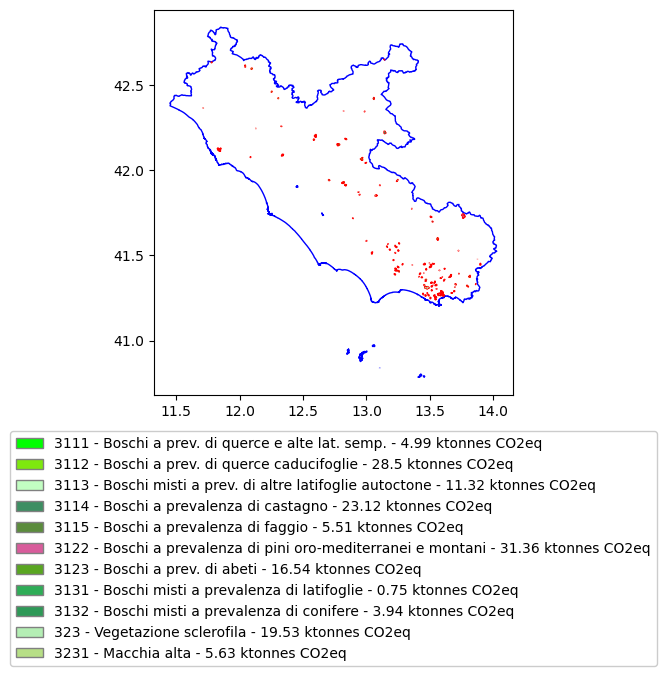

In [35]:
######## GHG CALCULATION ################
#######################################
#import initial data: forest classes and burnt shape
forest_classes, forest_labels, forest_colors = get_landcover_classes(landcover,landcover_legend_table,language)
burnt_shape = import_data(effis_shapefile,it_regions_shapefile,crs,region,COMMUNE=commune,PROVINCE=province,COUNTRY=country,YEAR=year,ID=fire_id)

# STEP 1. Get total burnt area (A) for each vegetation type within burnt shape
if landcover == "EFFIS":
    A,_ = get_total_burnt_area(landcover,clc18_landcover,burnt_shape,forest_classes, crs)
else:
    A,A_by_event = get_total_burnt_area(landcover,clc18_landcover,burnt_shape,forest_classes, crs)

# STEP 2. Get biomass of available fuel (B) for each vegetation type
B = get_biomass(INFC15_lookup_table, biomass_table, landcover, region)

# STEP 3. Get combustion factor (C) for each vegetation type
C = get_combustion_factor(c_factor_bovio_conversion_table,fire_damage_table,landcover,scorch_height)

# STEP 4. Get emission factors (D) for each GHG compound
D = get_emission_factors(emission_factors_table)

# STEP 5. Calculate total GHG emissions from emission factors
ghg, ghg_std, ghg_all_events = get_total_ghg_emissions(A,B,C,D,landcover)

#check Total GHG per year
print("total GHG emissions for the year " + str(year)  +" in " + str(region) +" region in "
      + str(np.round(ghg,2))+ " +/- " + str(np.round(ghg_std,2))+ " ktonnes CO2eq")


plot_burnt_area_and_forest_classes(landcover_legend_table,clc18_landcover,it_regions_shapefile,region,language,burnt_shape,ghg_all_events,crs,
                                   plot_region=True)

# save_ghg_emissions(ghg, A, ghg_output_table,year,country,region,province,commune)
